# Analysis of Camden's Diabetes Prevalence and Deprivation by Lower Layer Super Output Area (LSOA)

This notebook carries out exploratory analysis of the geographic variation in Diabetes Prevalence and Deprivation across Camden, and of the relationship between Deprivation and Diabetes Prevalence in Camden. The analysis is at LSOA level. These are small geographical areas [devised by the ONS](http://neighbourhood.statistics.gov.uk/HTMLDocs/nessgeography/superoutputareasexplained/output-areas-explained.htm) for statistical reporting purposes. There are 133 of these in  Camden. 

Given that Diabetes Prevalence (and morbidity prevalence in general) is not reported at LSOA level, an estimate of LSOA Diabetes Prevalence has initially been established using a method outlined and coded below. As the time restrictions of this project are fairly tight this is quite a brief analysis but it may well be the case that the attribution method will be useful as we progress to further develop the predictive models and other analysis.


In [9]:
import pandas as pd
import numpy as np

# read in csvs to dataframes
df = pd.read_csv('DataForExamples/camden_lsoa_codes.csv')
df2 = pd.read_csv('DataForExamples/LSOA-Alt-Format-tall.csv')
df4 = pd.read_csv('DataForExamples/Diabetes_Prevalence_2016.csv')
df7 = pd.read_csv('DataForExamples/IMD.csv')
df8 = pd.read_csv('DataForExamples/IMD_2015_Living_Environment_Sub_Indicators.csv')

In [10]:
# This is Python code that loads up my R home environment with all the libraries I've installed etc. 
import os
os.environ['R_HOME'] = "/Library/Frameworks/R.framework/Resources"
print os.environ['R_HOME']
%load_ext rpy2.ipython
from rpy2.robjects import pandas2ri

/Library/Frameworks/R.framework/Resources
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [11]:
%R library(dplyr)
%R library(broom)
%R library(tmap)
%R library(rgdal)
%R library(scatterplot3d)

array(['scatterplot3d', 'rgdal', 'sp', 'tmap', 'broom', 'dplyr', 'tools',
       'stats', 'graphics', 'grDevices', 'utils', 'datasets', 'methods',
       'base'],
      dtype='|S13')

## Load the geojson. 
The geojson file forms the basis for the choropleth charts, contained in it is a polygon for every LSOA in Camden. This data was downloaded as a .kml file [from here](https://data.gov.uk/dataset/lower_layer_super_output_area_lsoa_boundaries). This is a large file holding polygons for every LSOA in England so it was edited to keep only Camden's LSOAs and then converted to geojson format using [topojson](https://github.com/topojson/topojson/blob/master/README.md#geo2topo).

OGR data source with driver: GeoJSON 
Source: "DataForExamples/camden.json", layer: "OGRGeoJSON"
with 133 features
It has 17 fields


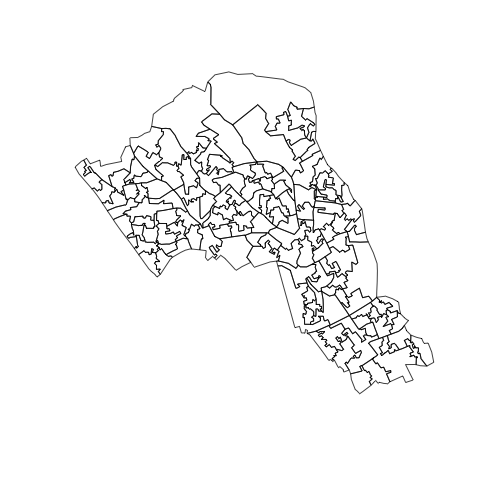

In [12]:
%%R 
map = readOGR("DataForExamples/camden.json", "OGRGeoJSON")
plot(map)

In [13]:
df3 = df2.loc[df2['LSOA_CODE'].isin(df['LSOA'])]

## Attribute diabetes prevalence for each LSOA in Camden
The cell below estimates diabetes prevalence for each LSOA in Camden. It does this by using [data listing the numbers of patients registered at a GP Practice at LSOA level](https://data.gov.uk/dataset/numbers-of-patients-registered-at-a-gp-practice-lsoa-level) and the diabetes prevalence for each GP practice from the QOF obtained [here](http://www.content.digital.nhs.uk/catalogue/PUB22266). 

The number of diabetics for each group of patients within a given Practice and LSOA combination is estimated by multiplying the diabetes prevalence for a Practice by the number of patients in that Practice for the given LSOA. The total number of patients for each group of patients within a given Practice and LSOA combination is also recorded. This is done for every group of patients in all Practices with patients who reside in a given LSOA. The diabetes prevalence for every LSOA is then estimated by summing all of the diabetic patients estimated for each Practice and dividing by the total number of patients in the given LSOA. 

Please note that this is an **_estimate_** of diabetes prevalence and that it also cannot currently be compared to the nationally published QOF reported diabetes prevalence for Practices as this estimate includes children aged 17 and under in its denominator whereas the published prevalence does not. It should however be a reasonable estimate - sufficient for our requirements to assess variation across Camden given that diabetes prevalence is not directly reported for low-level geographies like the LSOA.


In [14]:
# access every Practice-LSOA row for each LSOA in Camden.
# for each row access the diabetes prevalence for that Practice and attribute that prevalence to the patients 
# in the Practice-LSOA combination
data = []
for index1, row1 in df.iterrows():
    df5 = df3.loc[df3['LSOA_CODE'] == row1['LSOA']]
    
    total_patients_for_LSOA = 0
    total_diabetics_for_LSOA = 0
    
    for index2,row2 in df5.iterrows():
        
        # access diabetes prevalence for this Practice Code
        prev_for_practice = df4.loc[df4['Practice code'] == row2['PRACTICE_CODE']] 
        for index3, row3 in prev_for_practice.iterrows():
        
          list_size = pd.to_numeric(row3['All ages'])
          register = pd.to_numeric(row3['Register'])
          all_patients_for_LSOA = pd.to_numeric(row2['All Patients'])
          total_patients_for_LSOA = total_patients_for_LSOA + pd.to_numeric(row2['All Patients'])
          total_diabetics_for_LSOA  = total_diabetics_for_LSOA + (float(pd.to_numeric(row3['Register']))/pd.to_numeric(row3['All ages']))*pd.to_numeric(row2['All Patients'])
                                                
    keys = ['LSOA','total_patients_for_LSOA','total_diabetics_for_LSOA','prevalence']
    values = [row1['LSOA'],total_patients_for_LSOA,total_diabetics_for_LSOA,float(total_diabetics_for_LSOA)/total_patients_for_LSOA]
    
    data.append(dict(zip(keys,values)))

df6 = pd.DataFrame(data) 


## Plot choropleth charts displaying the variation in diabetes prevalence and different aspects of the Indices of Multiple Deprivation (IMD) across Camden.
The cell below initially joins the geographic, IMD and diabetes prevalence data for the LSOAs and then plots it as six choropleth charts. 

Six choropleth charts are plotted. The first displays estimated diabetes prevalence for each LSOA in Camden. The lighter the colour the lower the prevalence. Prevalence is variable across Camden - predominantly low in the central north, central west and far south-west (Highgate, Hampstead, Swiss Cottage, Bloomsbury and Holborn) and higher in the far west and central east areas (St Pancras and Somers Town, Kentish Town, Camden Town, Kilburn and Fortune Green). 

The other five charts display the variation in deprivation across Camden for the overall IMD and some of the different sub-categories of the IMD. The first, in the top right, displays the overall IMD for each LSOA in Camden. The overall IMD covers [seven aspects](https://en.wikipedia.org/wiki/Multiple_deprivation_index) of deprivation, the other four charts display the variation for the Barriers to Housing and Services, Crime, Education, Skills and Training, and Living Environment aspects respectively. 

Of the five IMD choropleth charts, the one that has the most similarity in variation across Camden to the Diabetes Prevalence choropleth chart is the Overall IMD chart. 


/Users/heatherdawe/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Joining, by = "lsoa11cd"

  warnings.warn(x, RRuntimeWarning)


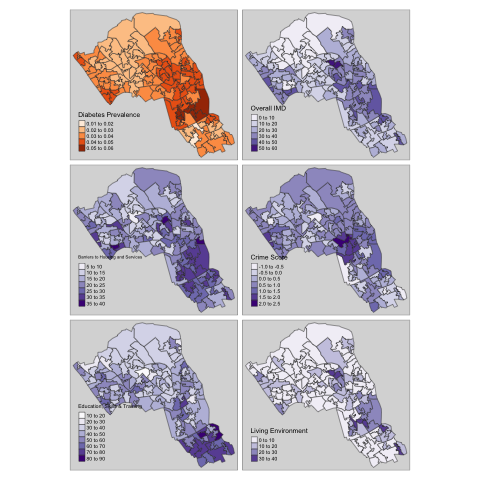

In [15]:
%%R -i df6

df6 <- rename(df6, lsoa11cd = LSOA)
df7 <- read.csv("DataForExamples/IMD.csv")
df7 <- rename(df7, lsoa11cd = LSOA)

map@data <- left_join(map@data, df6)
map@data <- left_join(map@data, df7)

par(mfrow=c(3,2))

pal8_1 <- c('#feedde','#fdd0a2','#fdae6b','#fd8d3c','#e6550d','#a63603')
pal8_2 <- c('#f2f0f7','#dadaeb','#bcbddc','#9e9ac8','#756bb1','#54278f')

tm_shape(map) +
    tm_polygons(c("prevalence","IMD","Barriers_to_Housing_and_Services_Score","Crime_Score", "Living_Environment_Score","Education_Skills_and_Training_Score"), 
        style=c("pretty", "kmeans"),
        palette=list(pal8_1,"Purples", "Purples","Purples", "Purples","Purples"),
        auto.palette.mapping=FALSE,
        title=c("Diabetes Prevalence","Overall IMD","Barriers to Housing and Services","Crime Score","Education, Skills & Training", "Living Environment")) + 
tm_style_grey()  


## The relationship between Deprivation and Diabetes Prevalence in Camden
#### The main purpose of this analysis is to investigate whether there is any apparent relationship between deprivation and diabetes prevalence in Camden, with a view to using a measure of deprivation as an explanatory variable in any predictive models if such a relationship appears to exist. 
From the scatter plot it appears that there is a relationship, and that generally the higher the deprivation the higher the diabetes prevalence. This relationship is reasonably strong and statistically significant (R-squared = 0.515 and a p-value much less than 5%). There is dispersion apparent and this analysis could perhaps benefit from a cluster analysis if there is time. 
The additional scatter plots confirm that the relationship between the overall IMD and diabetes prevalence is strongest when compared to the relationship between diabetes prevalence and the sub-aspects of the IMD. The relationship between prevalence and each of these aspects is statistically significant apart from that of the Living Environment aspect (R-squared = 0.0129 and p-value = 0.1). 


/Users/heatherdawe/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Joining, by = c("lsoa11cd", "prevalence", "total_diabetics_for_LSOA", "total_patients_for_LSOA")

  warnings.warn(x, RRuntimeWarning)
/Users/heatherdawe/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Joining, by = c("lsoa11cd", "LSOA.name..2011.", "Local.Authority.District.code..2013.", "Local.Authority.District.name..2013.", "IMD", "Index.of.Multiple.Deprivation..IMD..Rank..where.1.is.most.deprived.", "Index.of.Multiple.Deprivation..IMD..Decile..where.1.is.most.deprived.10..of.LSOAs.", "Income_score", "Income.Rank..where.1.is.most.deprived.", "Income.Decile..where.1.is.most.deprived.10..of.LSOAs.", "Employment_Score", "Employment.Rank..where.1.is.most.deprived.", "Employment.Decile..where.1.is.most.deprived.10..of.LSOAs.", "Education_Skills_and_Training_Score", "Education..Skills.and.Training.Rank..where.1.is.most.deprived.", "Education..Ski

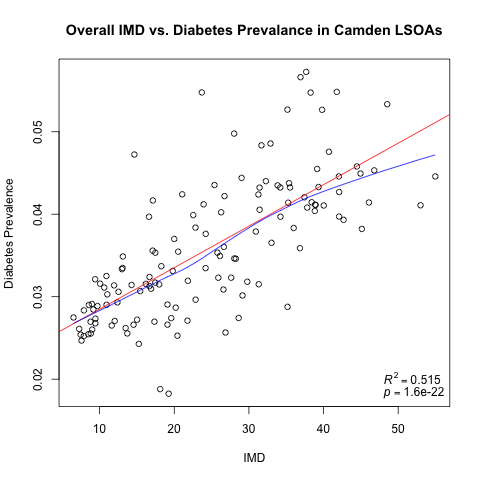

In [16]:
%%R -i df6
df6 <- rename(df6, lsoa11cd = LSOA)
df7 <- read.csv("DataForExamples/IMD.csv")
df7 <- rename(df7, lsoa11cd = LSOA)
map@data <- left_join(map@data, df6)
map@data <- left_join(map@data, df7)
plot(map@data$IMD,map@data$prevalence,xlab='IMD',ylab='Diabetes Prevalence')
abline(fit<-lm(map@data$prevalence~map@data$IMD,data=map@data),col="red")
lines(lowess(map@data$IMD,map@data$prevalence),col="blue")
title('Overall IMD vs. Diabetes Prevalance in Camden LSOAs')
rp = vector('expression',2)
rp[1] = substitute(expression(italic(R)^2 == MYVALUE), 
		list(MYVALUE = format(summary(fit)$adj.r.squared,dig=3)))[2]
rp[2] = substitute(expression(italic(p) == MYOTHERVALUE), 
		list(MYOTHERVALUE = format(anova(fit)$"Pr(>F)"[1], digits = 2)))[2]
legend('bottomright', legend = rp, bty = 'n')


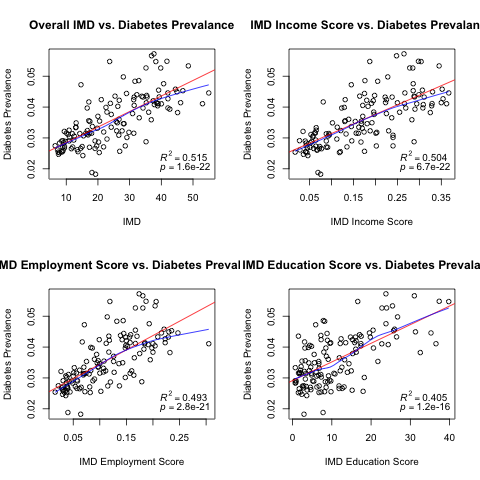

In [17]:
%%R -i df6

df6 <- rename(df6, lsoa11cd = LSOA)
df7 <- read.csv("DataForExamples/IMD.csv")
df7 <- rename(df7, lsoa11cd = LSOA)
map@data <- left_join(map@data, df6)
map@data <- left_join(map@data, df7)

par(mfrow=c(2,2))

plot(map@data$IMD,map@data$prevalence,xlab='IMD',ylab='Diabetes Prevalence')
abline(fit<-lm(map@data$prevalence~map@data$IMD,data=map@data),col="red")
lines(lowess(map@data$IMD,map@data$prevalence),col="blue")
title('Overall IMD vs. Diabetes Prevalance')
rp = vector('expression',2)
rp[1] = substitute(expression(italic(R)^2 == MYVALUE), 
		list(MYVALUE = format(summary(fit)$adj.r.squared,dig=3)))[2]
rp[2] = substitute(expression(italic(p) == MYOTHERVALUE), 
		list(MYOTHERVALUE = format(anova(fit)$"Pr(>F)"[1], digits = 2)))[2]
legend('bottomright', legend = rp, bty = 'n')

plot(map@data$Income_score,map@data$prevalence,xlab='IMD Income Score',ylab='Diabetes Prevalence')
abline(fit<-lm(map@data$prevalence~map@data$Income_score,data=map@data),col="red")
lines(lowess(map@data$Income_score,map@data$prevalence),col="blue")
title('IMD Income Score vs. Diabetes Prevalance')
rp = vector('expression',2)
rp[1] = substitute(expression(italic(R)^2 == MYVALUE), 
		list(MYVALUE = format(summary(fit)$adj.r.squared,dig=3)))[2]
rp[2] = substitute(expression(italic(p) == MYOTHERVALUE), 
		list(MYOTHERVALUE = format(anova(fit)$"Pr(>F)"[1], digits = 2)))[2]
legend('bottomright', legend = rp, bty = 'n')

plot(map@data$Employment_Score,map@data$prevalence,xlab='IMD Employment Score',ylab='Diabetes Prevalence')
abline(fit<-lm(map@data$prevalence~map@data$Employment_Score,data=map@data),col="red")
lines(lowess(map@data$Employment_Score,map@data$prevalence),col="blue")
title('IMD Employment Score vs. Diabetes Prevalance')
rp = vector('expression',2)
rp[1] = substitute(expression(italic(R)^2 == MYVALUE), 
		list(MYVALUE = format(summary(fit)$adj.r.squared,dig=3)))[2]
rp[2] = substitute(expression(italic(p) == MYOTHERVALUE), 
		list(MYOTHERVALUE = format(anova(fit)$"Pr(>F)"[1], digits = 2)))[2]
legend('bottomright', legend = rp, bty = 'n')

plot(map@data$Education_Skills_and_Training_Score,map@data$prevalence,xlab='IMD Education Score',ylab='Diabetes Prevalence')
abline(fit<-lm(map@data$prevalence~map@data$Education_Skills_and_Training_Score,data=map@data),col="red")
lines(lowess(map@data$Education_Skills_and_Training_Score,map@data$prevalence),col="blue")
title('IMD Education Score vs. Diabetes Prevalance')
rp = vector('expression',2)
rp[1] = substitute(expression(italic(R)^2 == MYVALUE), 
		list(MYVALUE = format(summary(fit)$adj.r.squared,dig=3)))[2]
rp[2] = substitute(expression(italic(p) == MYOTHERVALUE), 
		list(MYOTHERVALUE = format(anova(fit)$"Pr(>F)"[1], digits = 2)))[2]
legend('bottomright', legend = rp, bty = 'n')

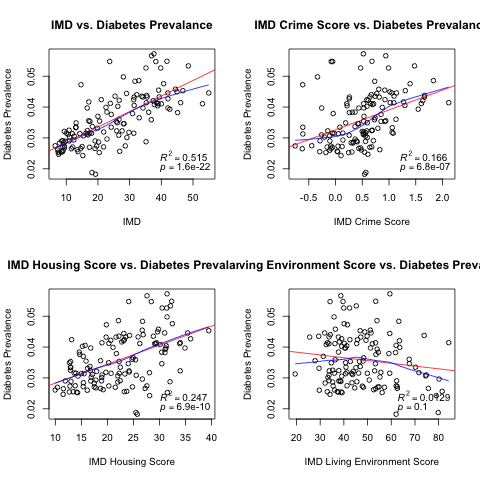

In [18]:
%%R
par(mfrow=c(2,2))

plot(map@data$IMD,map@data$prevalence,xlab='IMD',ylab='Diabetes Prevalence')
abline(fit<-lm(map@data$prevalence~map@data$IMD,data=map@data),col="red")
lines(lowess(map@data$IMD,map@data$prevalence),col="blue")
title('IMD vs. Diabetes Prevalance')
rp = vector('expression',2)
rp[1] = substitute(expression(italic(R)^2 == MYVALUE), 
		list(MYVALUE = format(summary(fit)$adj.r.squared,dig=3)))[2]
rp[2] = substitute(expression(italic(p) == MYOTHERVALUE), 
		list(MYOTHERVALUE = format(anova(fit)$"Pr(>F)"[1], digits = 2)))[2]
legend('bottomright', legend = rp, bty = 'n')

plot(map@data$Crime_Score,map@data$prevalence,xlab='IMD Crime Score',ylab='Diabetes Prevalence')
abline(fit<-lm(map@data$prevalence~map@data$Crime_Score,data=map@data),col="red")
lines(lowess(map@data$Crime_Score,map@data$prevalence),col="blue")
title('IMD Crime Score vs. Diabetes Prevalance')
rp = vector('expression',2)
rp[1] = substitute(expression(italic(R)^2 == MYVALUE), 
		list(MYVALUE = format(summary(fit)$adj.r.squared,dig=3)))[2]
rp[2] = substitute(expression(italic(p) == MYOTHERVALUE), 
		list(MYOTHERVALUE = format(anova(fit)$"Pr(>F)"[1], digits = 2)))[2]
legend('bottomright', legend = rp, bty = 'n')

plot(map@data$Barriers_to_Housing_and_Services_Score,map@data$prevalence,xlab='IMD Housing Score',ylab='Diabetes Prevalence')
abline(fit<-lm(map@data$prevalence~map@data$Barriers_to_Housing_and_Services_Score,data=map@data),col="red")
lines(lowess(map@data$Barriers_to_Housing_and_Services_Score,map@data$prevalence),col="blue")
title('IMD Housing Score vs. Diabetes Prevalance')
rp = vector('expression',2)
rp[1] = substitute(expression(italic(R)^2 == MYVALUE), 
		list(MYVALUE = format(summary(fit)$adj.r.squared,dig=3)))[2]
rp[2] = substitute(expression(italic(p) == MYOTHERVALUE), 
		list(MYOTHERVALUE = format(anova(fit)$"Pr(>F)"[1], digits = 2)))[2]
legend('bottomright', legend = rp, bty = 'n')

plot(map@data$Living_Environment_Score,map@data$prevalence,xlab='IMD Living Environment Score',ylab='Diabetes Prevalence')
abline(fit<-lm(map@data$prevalence~map@data$Living_Environment_Score,data=map@data),col="red")
lines(lowess(map@data$Living_Environment_Score,map@data$prevalence),col="blue")
title('Living Environment Score vs. Diabetes Prevalance')
rp = vector('expression',2)
rp[1] = substitute(expression(italic(R)^2 == MYVALUE), 
		list(MYVALUE = format(summary(fit)$adj.r.squared,dig=3)))[2]
rp[2] = substitute(expression(italic(p) == MYOTHERVALUE), 
		list(MYOTHERVALUE = format(anova(fit)$"Pr(>F)"[1], digits = 2)))[2]
legend('bottomright', legend = rp, bty = 'n')


## Analysis of the variation in air quality at LSOA level
The Living Environment aspect of the IMD itself consists of [four indicators](https://www.gov.uk/government/uploads/system/uploads/attachment_data/file/464485/English_Indices_of_Deprivation_2015_-_Technical-Report.pdf) 
* The proportion of houses without central heating
* The proportion of houses in a poor condition
* A measure of air quality based on four pollutants
* Road traffic accidents involving injury to pedestrians and cyclists

Although the Living Environment aspect of the IMD was found to have an insignificant relationship with diabetes prevalence, the Air Quality sub-indicator will be further reviewed to visualise its variation across the 133 LSOAs in Camden. 

The IMD sub-indicators were downloaded [here](https://www.gov.uk/government/statistics/english-indices-of-deprivation-2015). The choropleth chart of Air Quality across Camden shows clear and significant variation, with a clear deteriation in quality as the Euston Road is approched from the north. This deteriation continues as you move further south into the City. 


/Users/heatherdawe/anaconda/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Joining, by = c("lsoa11cd", "LSOA.name..2011.", "Local.Authority.District.code..2013.", "Local.Authority.District.name..2013.")

  warnings.warn(x, RRuntimeWarning)


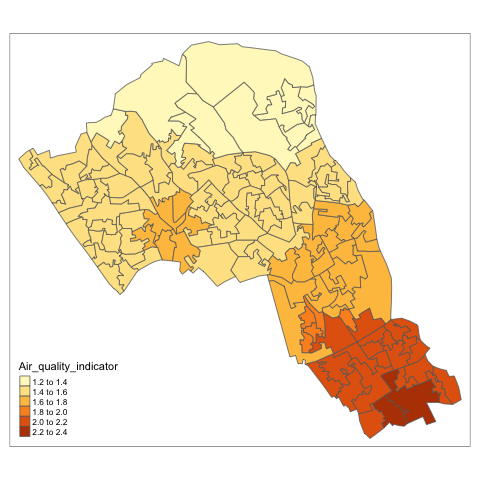

In [19]:
%%R -i df8

df8 <- rename(df8, lsoa11cd = LSOA)
map@data <- left_join(map@data, df8)

qtm(map, "Air_quality_indicator")



## Relationship between Diabetes Prevalence and Air Quality
A simple plot of Air Quality vs. Diabetes Prevalence immediately shows two clusters apparent. The LSOAs with the lowest air quality (> 2.0) are in their own cluster. Re-plotting the data without this cluster present and measuring the correlation suggests there is a significant relationship (R-squared = 0.399 p-value < 0.5).

For those LSOAs with the poorest quality air (2.0 and over), there is no apparent relationship with Diabetes Prevalence. Introducing a third variable - Income - and plotting a 3-D plot shows that Income can at least in part explain the variation in prevalence for this group.

From this we can conclude that, for those LSOAs with relatively good air quality, that air quality is a _*reasonably*_ good explanatory variable for Diabetes Prevalence. 

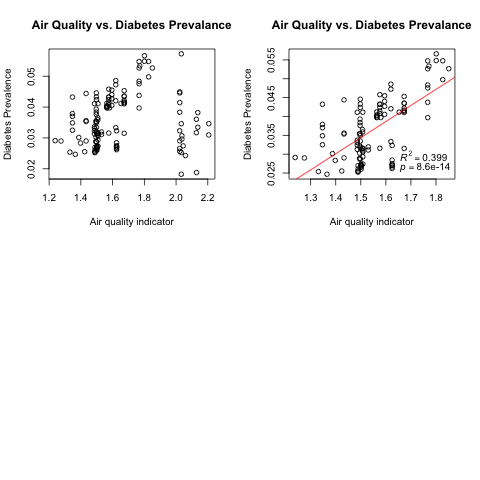

In [20]:
%%R 

par(mfrow=c(2,2))

plot(map@data$Air_quality_indicator,map@data$prevalence,xlab='Air quality indicator',ylab='Diabetes Prevalence')
title('Air Quality vs. Diabetes Prevalance')

plot(map@data$Air_quality_indicator[map@data$Air_quality_indicator<1.9],map@data$prevalence[map@data$Air_quality_indicator<1.9],xlab='Air quality indicator',ylab='Diabetes Prevalence')
title('Air Quality vs. Diabetes Prevalance')
abline(fit<-lm(map@data$prevalence[map@data$Air_quality_indicator<1.9]~map@data$Air_quality_indicator[map@data$Air_quality_indicator<1.9],data=map@data),col="red")
rp = vector('expression',2)
rp[1] = substitute(expression(italic(R)^2 == MYVALUE), 
		list(MYVALUE = format(summary(fit)$adj.r.squared,dig=3)))[2]
rp[2] = substitute(expression(italic(p) == MYOTHERVALUE), 
		list(MYOTHERVALUE = format(anova(fit)$"Pr(>F)"[1], digits = 2)))[2]
legend('bottomright', legend = rp, bty = 'n')


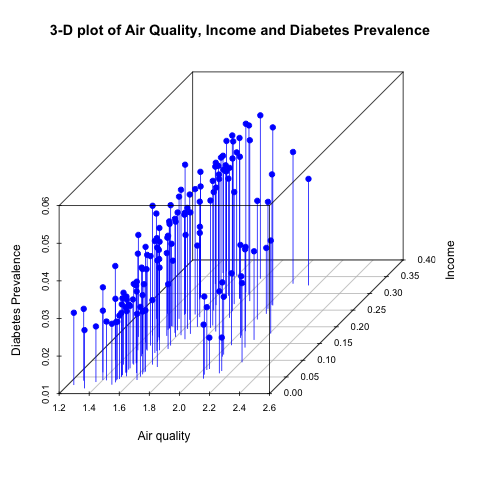

In [21]:
%%R

with(map@data, {
   scatterplot3d(
                 Air_quality_indicator,     # x axis
                 Income_score,    # y axis
                 prevalence,
                 color="blue", pch=19, # filled blue circles
                 type="h",
                 xlab = "Air quality",
                 ylab = "Income",
                 zlab = "Diabetes Prevalence",
                 main="3-D plot of Air Quality, Income and Diabetes Prevalence")
})

## Conclusion
This analysis has been brief through necessity rather than preference. Next steps will be to determine a measure of co-morbidity and then to incorporate this and the number of incidences of strokes and heart attacks into similar analyses to see if we can learn more about the variation in the incidence of outcomes and patient co-morbidity across Camden.

Given the clustering highlighted by simple plots it will probably be very useful to carry out further cluster analyses incorporating the IMD and some of its lower level indicators, as well a levels of co-morbidities. 


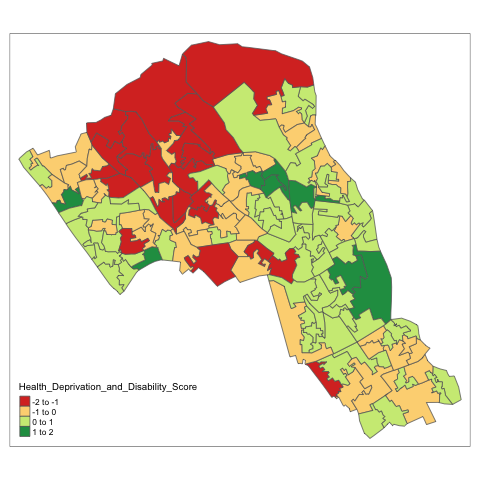

In [22]:
%%R 

qtm(map, "Health_Deprivation_and_Disability_Score")
